<a href="https://colab.research.google.com/github/Luana-lrb/LIPAI_Python/blob/main/onboarding/src/semana_13/Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Implementação U-Net**

In [1]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
Tesla T4


In [2]:
!pip install albumentations==1.4.0 opencv-python-headless

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.6/123.6 kB 8.1 MB/s eta 0:00:00
  Attempting uninstall: albumentations
    Found existing installation: albumentations 2.0.8
    Uninstalling albumentations-2.0.8:
      Successfully uninstalled albumentations-2.0.8


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
IMG_DIR = "/content/drive/MyDrive/unet_datasets/images_original"
MASK_DIR = "/content/drive/MyDrive/unet_datasets/gold_standart"


In [5]:
import os
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt

### **Bloco de Convolução**

In [22]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, batchnorm=True):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels) if batchnorm else nn.Identity(),
            nn.ReLU(inplace=True),

            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels) if batchnorm else nn.Identity(),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.block(x)

### **Encoder**

In [7]:
class Encoder(nn.Module):
    def __init__(self, in_channels, batchnorm=True):
        super().__init__()
        self.blocks = nn.ModuleList([
            ConvBlock(in_channels, 64, batchnorm),
            ConvBlock(64, 128, batchnorm),
            ConvBlock(128, 256, batchnorm),
            ConvBlock(256, 512, batchnorm),
        ])
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        skips = []
        for block in self.blocks:
            x = block(x)
            skips.append(x)
            x = self.pool(x)
        return x, skips


### **Bottleneck**

In [8]:
class Bottleneck(nn.Module):
    def __init__(self, batchnorm=True):
        super().__init__()
        self.block = ConvBlock(512, 1024, batchnorm)

    def forward(self, x):
        return self.block(x)

### **UpBlock**

In [9]:
class UpBlock(nn.Module):
    def __init__(self, in_ch, out_ch, batchnorm=True):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_ch, out_ch, 2, stride=2)
        self.conv = ConvBlock(out_ch * 2, out_ch, batchnorm)

    def forward(self, x, skip):
        x = self.up(x)
        x = torch.cat([x, skip], dim=1)
        return self.conv(x)

### **Decoder**

In [10]:
class Decoder(nn.Module):
    def __init__(self, batchnorm=True):
        super().__init__()
        self.blocks = nn.ModuleList([
            UpBlock(1024, 512, batchnorm),
            UpBlock(512, 256, batchnorm),
            UpBlock(256, 128, batchnorm),
            UpBlock(128, 64, batchnorm),
        ])
        self.final = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x, skips):
        skips = skips[::-1]
        for i in range(len(self.blocks)):
            x = self.blocks[i](x, skips[i])
        return self.final(x)

### **U-NET COMPLETA**

In [11]:
class UNet(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()
        self.encoder = Encoder(in_channels)
        self.bottleneck = Bottleneck()
        self.decoder = Decoder()

    def forward(self, x):
        x, skips = self.encoder(x)
        x = self.bottleneck(x)
        return self.decoder(x, skips)

Para o Dataset

In [12]:
class OralDataset(torch.utils.data.Dataset):
    def __init__(self, img_root, mask_root, transform=None):
        self.samples = []
        self.transform = transform

        for cls in ["healthy", "severe"]:
            img_dir = os.path.join(img_root, cls)
            mask_dir = os.path.join(mask_root, cls)

            imgs = sorted(os.listdir(img_dir))
            masks = sorted(os.listdir(mask_dir))

            for img_name, mask_name in zip(imgs, masks):
                self.samples.append((
                    os.path.join(img_dir, img_name),
                    os.path.join(mask_dir, mask_name)
                ))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, mask_path = self.samples[idx]

        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")

        img = np.array(img)
        mask = np.array(mask)

        if self.transform:
            aug = self.transform(image=img, mask=mask)
            img = aug["image"]
            mask = aug["mask"]

        img = img.float() / 255.0
        mask = (mask > 0).float()

        return img, mask.unsqueeze(0)

### **Aumento de Dados**

In [13]:
transform_no_aug = A.Compose([
    A.Resize(224, 224),
    ToTensorV2()
])

transform_aug = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=30, p=0.5),
    ToTensorV2()
])

### **Métricas**

In [14]:
def dice(pred, mask):
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()
    inter = (pred * mask).sum()
    return (2 * inter) / (pred.sum() + mask.sum() + 1e-8)

def iou(pred, mask):
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()
    inter = (pred * mask).sum()
    union = pred.sum() + mask.sum() - inter
    return inter / (union + 1e-8)

def acc(pred, mask):
    pred = torch.sigmoid(pred)
    pred = (pred > 0.5).float()
    return (pred == mask).float().mean()

### **Treinamento**

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = UNet().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()

In [16]:
def train_epoch(loader):
    model.train()
    d, i, a = 0, 0, 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()

        d += dice(out, y).item()
        i += iou(out, y).item()
        a += acc(out, y).item()

    n = len(loader)
    return d/n, i/n, a/n

In [21]:
train_ds = OralDataset(
    IMG_DIR,
    MASK_DIR,
    transform_no_aug
)

# small_ds = torch.utils.data.Subset(train_ds, range(20))
# small_loader = DataLoader(small_ds, batch_size=4)

# for epoch in range(2):
#     d, i, a = train_epoch(small_loader)
#     print(f"Epoch {epoch+1}: Dice={d:.4f}")


In [18]:
loader = DataLoader(
    train_ds,
    batch_size=4,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

for epoch in range(10):
    d, i, a = train_epoch(loader)
    print(f"Epoch {epoch+1}: Dice={d:.4f} IoU={i:.4f} Acc={a:.4f}")

Epoch 1: Dice=0.6889 IoU=0.5280 Acc=0.8038
Epoch 2: Dice=0.7325 IoU=0.5795 Acc=0.8362
Epoch 3: Dice=0.7537 IoU=0.6073 Acc=0.8500
Epoch 4: Dice=0.7693 IoU=0.6264 Acc=0.8624
Epoch 5: Dice=0.7874 IoU=0.6508 Acc=0.8747
Epoch 6: Dice=0.7941 IoU=0.6597 Acc=0.8798
Epoch 7: Dice=0.8029 IoU=0.6717 Acc=0.8867
Epoch 8: Dice=0.8153 IoU=0.6893 Acc=0.8940
Epoch 9: Dice=0.8273 IoU=0.7065 Acc=0.9015
Epoch 10: Dice=0.8364 IoU=0.7194 Acc=0.9068


### **Comparação de resultado**

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

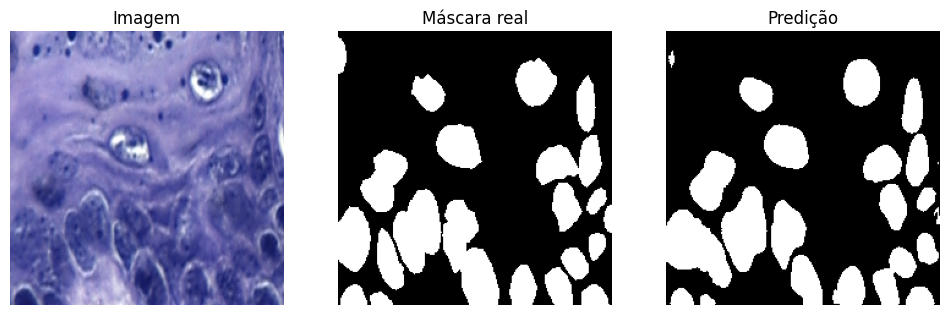

In [20]:
model.eval()
i = np.random.randint(len(train_ds))
x, y = train_ds[i]
with torch.no_grad():
    pred = model(x.unsqueeze(0).to(device))

plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.imshow(x.permute(1,2,0))
plt.title("Imagem")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(y[0], cmap="gray")
plt.title("Máscara real")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow((torch.sigmoid(pred)[0,0] > 0.5).cpu(), cmap="gray")
plt.title("Predição")
plt.axis("off")
